# Reservoirs in Andalucía
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 15-03-2024<br>

**Introduction:**<br>
This code preprocesses the reservoir timeseries from [Hidrosur](http://www.redhidrosurmedioambiente.es/saih/datos/a/la/carta). 

The raw data included the table of attributes of all the stations in the Hidrosur network, hourly time series of reservoir storage and level, and hourly time series of stage and discharge at gauging stations located inmediately upstream of some reservoirs.

The outputs are divided in two categories: gauges and reservoirs. In each case, a CSV file summarizes the attributes of all the station of that category, and a CSV contains the time series for each of those stations.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm.notebook import tqdm
import re
import requests

from utils.SNCZI import reservoir_attributes, dam_attributes

In [26]:
# path where the data is stored
path_datasets = Path('Z:/nahaUsers/casadje/datasets/')
path_hidrosur = path_datasets / 'Hidrosur'
path_cedex = path_datasets / 'CEDEX/processed/reservoirs/attributes/GIS/'

In [ ]:
path_GIS = path_hidrosur / 'processed' / 'GIS'
path_GIS.mkdir(parents=True, exist_ok=True)

## Stations

In [6]:
# import station metadata
stations = pd.read_csv(path_hidrosur / 'raw' / 'attributes' / 'stations.csv')

# rename columns
stations.rename(columns={'Estacion': 'ID',
                         'Nombre': 'name',
                         'Provincia': 'province',
                         'Tipo': 'type',
                         'Temperatura': 'temp',
                         'Pluviometria': 'precip',
                         'Nivometria': 'snow'},
                inplace=True)
stations.set_index('ID', drop=True, inplace=True)

# rename stations
stations.name = [name[:-5] for name in stations.name]
# correct reservoir names
names = []
for name in stations.name:
    # remove string 'embalse' from name
    name = re.sub(r'EMBALSE DE\s+', '', name)
    name = re.sub(r'EMBALSE DEL\s+', 'EL ', name)
    name = re.sub(r'EMBALSE\s+', '', name)
    names.append(name)
stations.name = names

# translate station type
stations['type'].replace({'PLUVIOMÉTRICA': 'PLUVIO',
                          'AFORO': 'GAUGE',
                          'METEOROLÓGICA': 'METEO',
                          'DISTRIBUCIÓN': 'SUPPLY',
                          'EMBALSE': 'RESERVOIR'},
                         inplace=True)

# convert fields representing variable to boolean
stations.temp.replace({'T': True, ' ': False, 'nan': np.nan}, inplace=True)
stations.precip.replace({'P': True, ' ': False, 'nan': np.nan}, inplace=True)
stations.snow.replace({'N': True, ' ': False, 'nan': np.nan}, inplace=True)

# covert to GeoDataFrame
stations = gpd.GeoDataFrame(stations, geometry=[Point(xy) for xy in zip(stations.X, stations.Y)], crs=25830)
stations = stations.to_crs('epsg:4326')
stations['lon'] = stations.geometry.x.round(6)
stations['lat'] = stations.geometry.y.round(6)

stations.head()

,name,province,type,X,Y,Z,temp,precip,snow,geometry,lon,lat
ID,,,,,,,,,,,,
1,SIERRA MIJAS,Málaga,METEO,357340.0,4052598.0,921.0,True,True,False,POINT (-4.59515 36.60823),-4.595146,36.608231
2,SIERRA DE LUNA,Cádiz,METEO,271235.0,3997849.0,820.0,True,True,False,POINT (-5.54114 36.09837),-5.541137,36.098368
3,CHARCO REDONDO,Cádiz,RESERVOIR,271556.0,4012820.0,105.0,True,True,False,POINT (-5.54193 36.23328),-5.541927,36.233284
4,DEPÓSITO REGULADOR CHARCO RDO,Cádiz,SUPPLY,273270.0,4011486.0,79.0,False,True,False,POINT (-5.52249 36.22167),-5.522486,36.221673
5,TORRE TOMA DE CHARCO REDONDO,Cádiz,SUPPLY,272856.0,4012339.0,91.0,False,True,False,POINT (-5.52734 36.22926),-5.527335,36.229259


In [7]:
# export shapefile
stations.to_file(path_GIS / 'stations_hidrosur.shp')

<font color='red'>There are IDs that repeat!!</font>

## Gauging stations

In [9]:
# import time series
HQ = pd.read_csv(path_hidrosur / 'raw' / 'timeseries' / 'nivelcaudalrios.txt', index_col=0, parse_dates=True, dayfirst=False)
HQ.index.name = 'ID'
HQ.columns = ['sensor', 'datetime', 'stage', 'discharge']
HQ.datetime = pd.to_datetime(HQ.datetime)

# reorganize the data
gauge_ts = {}
for ID in HQ.index.unique():
    HQ_i = HQ.loc[ID].copy()
    HQ_i.set_index('datetime', drop=True, inplace=True)
    HQ_i.drop('sensor', axis=1, inplace=True)
    gauge_ts[ID] = HQ_i

### Attributes

In [11]:
# export attributes of the gauging stations
path_attr = path_hidrosur / 'processed' / 'gauges' / 'attributes'
path_attr.mkdir(parents=True, exist_ok=True)
mask_gauge = stations.loc[stations['type'] == 'GAUGE'].index
stations.loc[mask_gauge].drop('geometry', axis=1).to_csv(path_attr / 'gauges_hidrosur.csv')

### Time series

  0%|          | 0/9 [00:00<?, ?it/s]

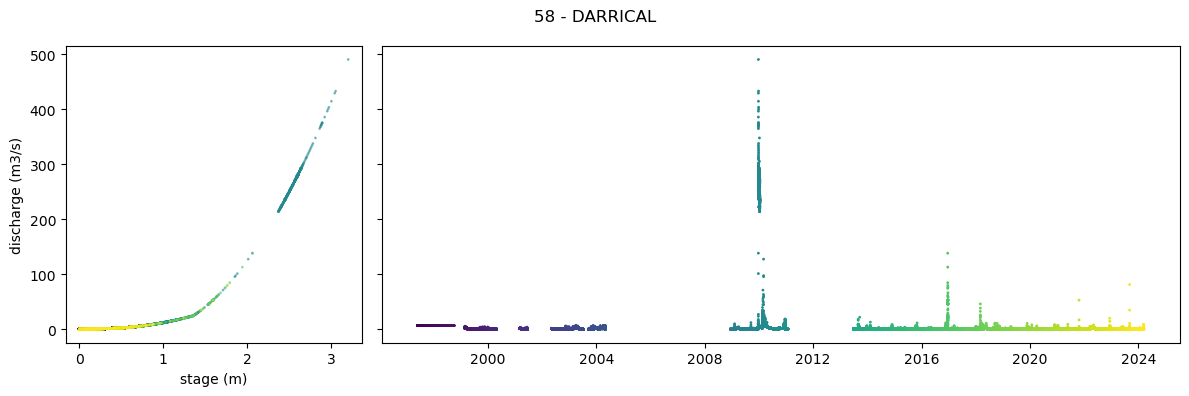

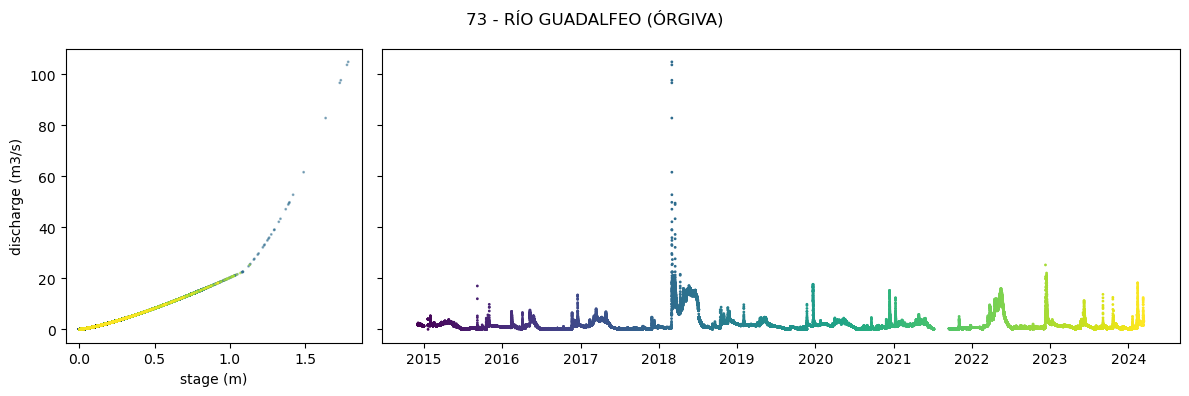

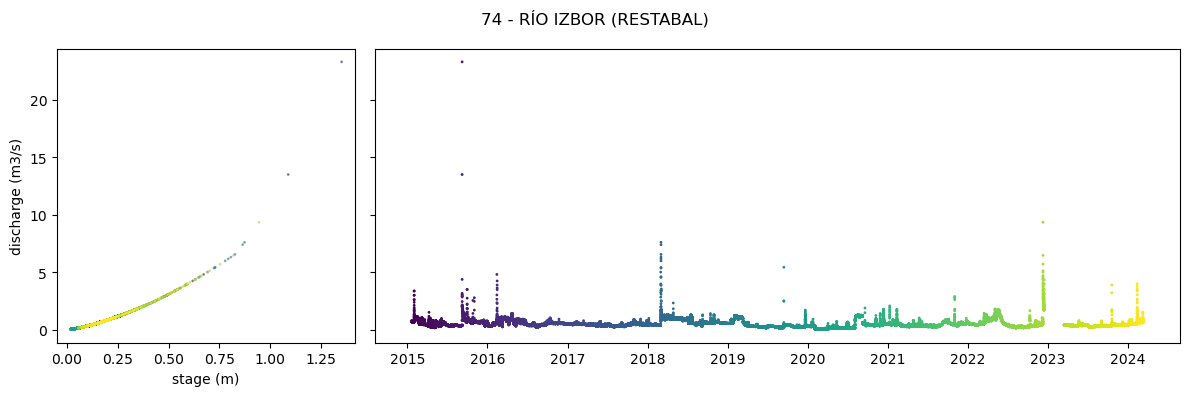

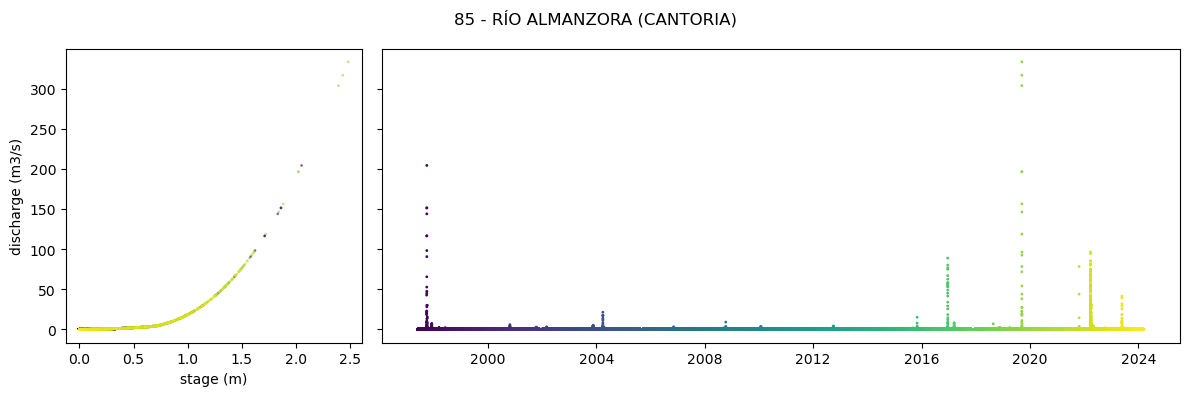

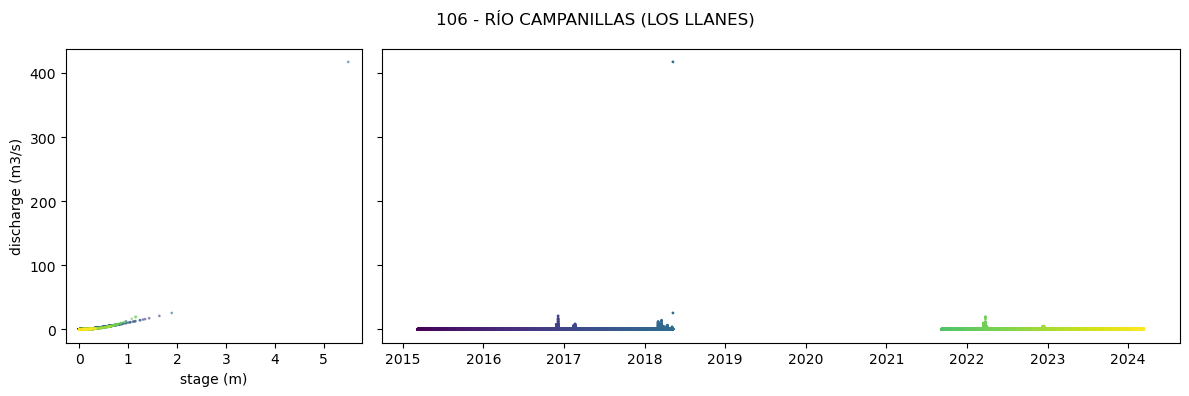

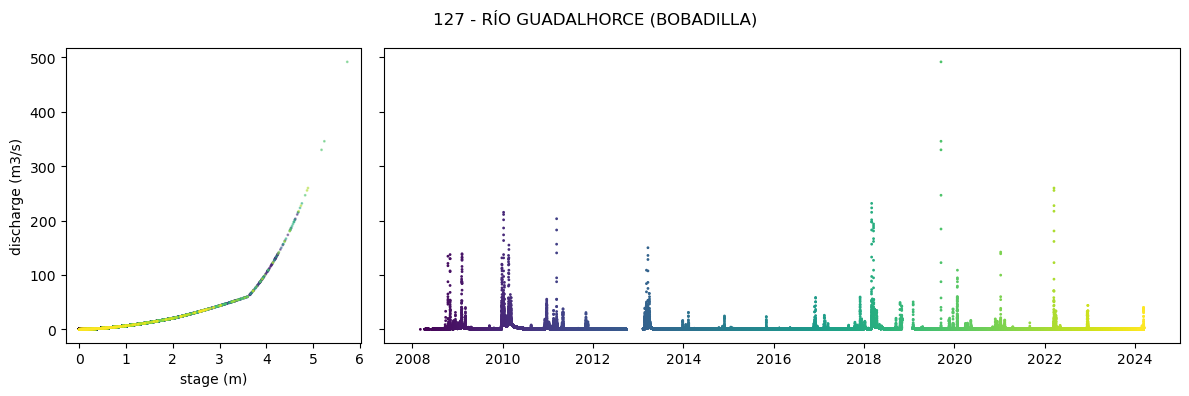

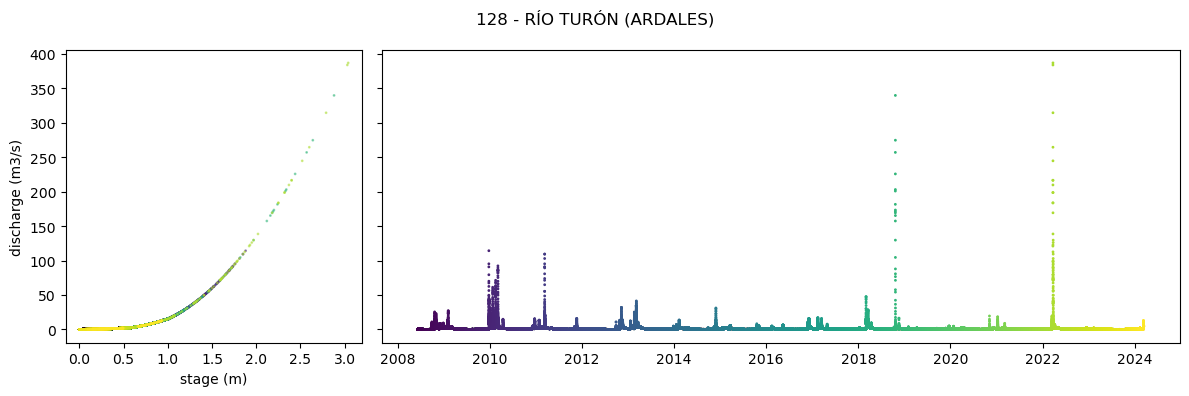

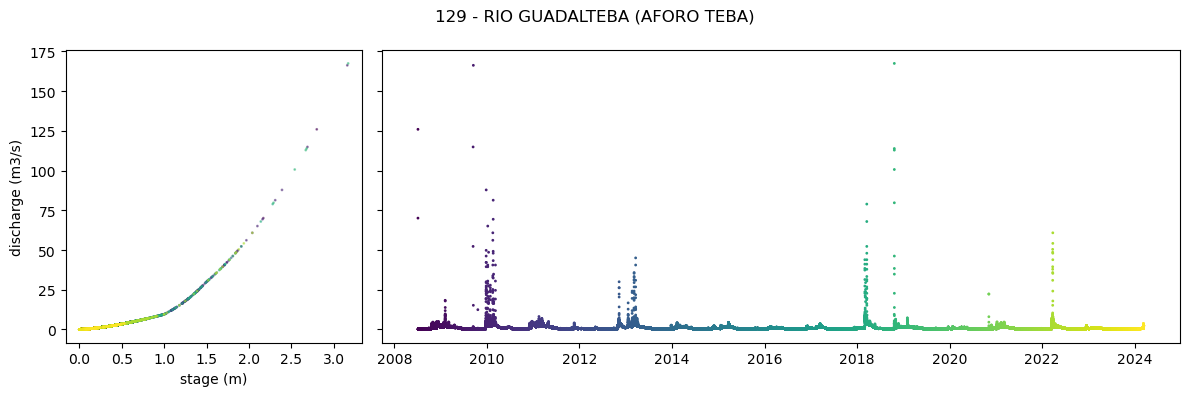

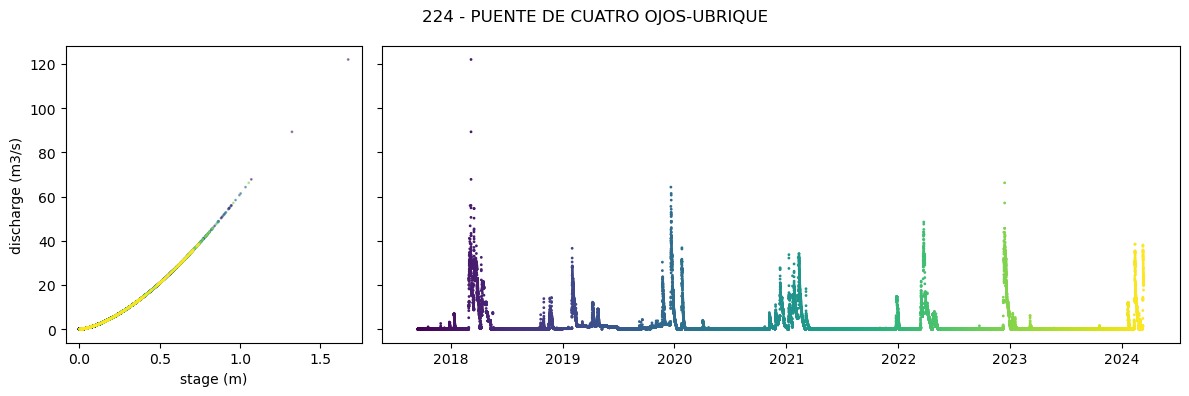

In [12]:
# export time series
path_ts = path_hidrosur / 'processed' / 'gauges' / 'timeseries'
path_plot = path_ts / 'plots'
path_plot.mkdir(parents=True, exist_ok=True)
for ID, df in tqdm(gauge_ts.items()):
   
    # export
    df.to_csv(path_ts / f'{ID:03}.csv')

    # plot
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, gridspec_kw={'width_ratios': [1, 2.7]}, tight_layout=True)
    ax[0].scatter(df.stage, df.discharge, s=1, c=df.index, cmap='viridis', alpha=.5)
    ax[0].set(xlabel='stage (m)',
              ylabel='discharge (m3/s)')
    ax[1].scatter(df.index, df.discharge, s=1, c=df.index, cmap='viridis')
    fig.suptitle('{0} - {1}'.format(ID, stations.loc[stations['type'] == 'GAUGE'].loc[ID, 'name']));
    plt.savefig(path_plot / f'{ID:03}.jpg', dpi=300, bbox_inches='tight')

## Reservoirs

In [18]:
# correspondence between the reservoir ID and the gauge ID that represents the inflow to that reservoir
map_reservoir_gauge = {31: 128,
                       29: 129,
                       30: 127,
                       19: 106,
                       58: 58,
                       64: 74,
                       84: 85}

In [19]:
# import time series
LV = pd.read_csv(path_hidrosur / 'raw' / 'timeseries' / 'nivelvolum.txt', index_col=0, parse_dates=True, dayfirst=False)
LV.index.name = 'ID'
LV.columns = ['datetime', 'level', 'volume']
LV.datetime = pd.to_datetime(LV.datetime)

# reorganize data by ID
reservoir_ts = {}
for ID in tqdm(LV.index.unique().tolist()):
    # extract time series for the reservoir ID
    LV_i = LV.loc[ID].copy()
    LV_i.set_index('datetime', drop=True, inplace=True)
    
    # correct erroneous level values
    LV_i.loc[LV_i.level <= 0, 'level'] = np.nan
    
    # add inflow from associated gauging station
    if ID in map_reservoir_gauge.keys():
        gauge_id = map_reservoir_gauge[ID]
        LV_i['inflow'] = gauge_ts[gauge_id]['discharge']
    
    # save in the dictionary
    reservoir_ts[ID] = LV_i

  0%|          | 0/20 [00:00<?, ?it/s]

### Time series

In [ ]:
path_ts = path_hidrosur / 'processed' / 'reservoirs' / 'timeseries' 
path_plot = path_ts / 'plots'
path_plot.mkdir(parents=True, exist_ok=True)
for ID, df in tqdm(reservoir_ts.items()):
    
    # export
    df.to_csv(path_ts / f'{ID:03}.csv')
    
    # plot
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, gridspec_kw={'width_ratios': [1, 2.7]}, tight_layout=True)
    ax[0].scatter(df.level, df.volume, s=1, c=df.index, cmap='viridis', alpha=.5)
    ax[0].set(xlabel='level (m)',
              ylabel='volume (hm3)')
    ax[1].scatter(df.index, df.volume, s=1, c=df.index, cmap='viridis')
    fig.suptitle('{0} - {1}'.format(ID, stations.loc[mask_reservoir].loc[ID, 'name']))
    plt.savefig(path_plot / f'{ID:03}.jpg', dpi=300, bbox_inches='tight')

### Attributes

In [73]:
# extract reservoirs from stations
mask_reservoir = stations['type'] == 'RESERVOIR'
reservoirs_sur = stations.loc[mask_reservoir].copy()
reservoirs_sur.drop(['type', 'temp', 'precip', 'snow'], axis=1, inplace=True)

#### Attributes from SCNZI

I extract from the Spanish Inventory of Dams and Reservoirs (_Sistema Nacional de Cartografía de Zonas Inundables_) other reservoir and dam attributes (volume, normal level, river elevation...), to be later on added to `reservoirs_sur`.

In [74]:
# correspondence between IDs in Hidrosur and the reservoir ID in the Spanish Invetory of Dams and Reservoirs
# I have derived this correspondence manually in QGIS!!!
map_hidrosur_snczi = {3: 659,
                      8: 1078,
                      16: 3499,
                      19: 556,
                      20: 1255,
                      29: 1075,
                      30: 1066,
                      31: 725,
                      37: 2511,
                      51: 1964,
                      58: 328,
                      64: 342,
                      84: 793,
                      269: 2539,
                      270: 369,
                      271: 165,
                      272: 1146,
                      273: 1062,
                      275: 257,
                      276: 616,
                      277: 121}
reservoirs_sur['SNCZI'] = [map_hidrosur_snczi[ID] for ID in reservoirs_sur.index]
reservoirs_sur.SNCZI = reservoirs_sur.SNCZI.astype('Int64')

##### Reservoir attributes

I will only download the reservoir reports from SNCZI. I will load this reports (`cedex_res`) only because they allow me to connect each reservoir with its main dam, but I will not add any attribute from them to `reservoirs_sur`.

In [75]:
# shapefile of reservoirs in the Spanish inventory
reservoirs_SNCZI = gpd.read_file(path_cedex / 'egis_embalse_geoetrs89.shp')
reservoirs_SNCZI['ID_EMBALSE'] = reservoirs_SNCZI['ID_EMBALSE'].astype(int)
reservoirs_SNCZI.set_index('ID_EMBALSE', drop=True, inplace=True)
reservoirs_SNCZI.sort_index(axis=0, inplace=True)
reservoirs_SNCZI.to_crs(epsg=25830, inplace=True)

print('SNCZI contains {0} reservoirs and {1} attributes'.format(*reservoirs_SNCZI.shape))
# reservoirs_SNCZI.head()

SNCZI contains 3170 reservoirs and 18 attributes


In [76]:
# download reports
path_reports_res = path_datasets / 'SNCZI' / 'reports' / 'reservoirs'
path_reports_res.mkdir(parents=True, exist_ok=True)
for ID in tqdm(reservoirs_sur.SNCZI):
    
    if pd.isna(ID):
        continue

    # output XML file
    filename = f'{path_reports_res}/{ID:04}.xml'
    if os.path.isfile(filename):
        continue
    
    # extract data from URL
    url = f'https://sig.mapama.gob.es/WebServices/clientews/snczi/Default.aspx?nombre=EGISPE_EMBALSE&claves=ID_EMBALSE&valores={ID}&op=ExpMultiple'
    
    with requests.get(url) as response:
        lines = [line.decode('utf-8') for line in response.iter_lines()]
    
    # export XML file
    with open(filename, 'w', encoding='utf-8') as file:
        file.writelines(line + '\n' for line in lines)

  0%|          | 0/21 [00:00<?, ?it/s]

In [77]:
# import reservoir attributes
cedex_res = pd.DataFrame(dtype='object')
for id_sur, id_snczi in tqdm(reservoirs_sur.SNCZI.items()):
    
    if pd.isna(id_snczi):
        continue
        
    file = f'{path_reports_res}/{id_snczi:04}.xml'
    try:
        cedex_res = pd.concat((cedex_res, reservoir_attributes(file, name=id_sur)), axis=1)
    except Exception as e:
        raise ValueError(f'File {file} could note be read: {str(e)}')

cedex_res = cedex_res.transpose()
cedex_res.index.name = 'ID'
cedex_res['Código del embalse'] = cedex_res['Código del embalse'].astype(int)

print('Imported from SNCZI {0} reservoirs and {1} attributes'.format(*cedex_res.shape))

0it [00:00, ?it/s]

Imported from SNCZI 21 reservoirs and 19 attributes


##### Dam attributes

In [78]:
# shapefile of dams in the Spanish inventory
dams_SNCZI = gpd.read_file(path_cedex / 'egis_presa_geoetrs89.shp')
cols_int = ['ID_INFRAES', 'CODIGO']
dams_SNCZI[cols_int] = dams_SNCZI[cols_int].astype(int)
dams_SNCZI.set_index('ID_INFRAES', drop=True, inplace=True)
dams_SNCZI.sort_index(inplace=True)
dams_SNCZI.to_crs(epsg=25830, inplace=True)

print('SNCZI contains {0} dams and {1} attributes'.format(*dams_SNCZI.shape))
# dams_SNCZI.head()

SNCZI contains 3208 dams and 23 attributes


In [79]:
# download reports
path_reports_dam = path_datasets / 'SNCZI' / 'reports' / 'dams'
path_reports_dam.mkdir(parents=True, exist_ok=True)
for id_sur in tqdm(reservoirs_sur.index):
    
    # find the ID of the dam
    try:
        code_infr = int(cedex_res.loc[id_sur, 'Código de infraestructura'])
    except Exception as e:
        print(f'Reservoir with ID {id_sur} does not have an infrastructure code')
        continue
    ID = dams_SNCZI.loc[dams_SNCZI.CODIGO == code_infr].index[0]

    # output XML file
    filename = f'{path_reports_dam}/{ID:04}.xml'
    if os.path.isfile(filename):
        continue
    
    # extract data from URL
    url = f'https://sig.mapama.gob.es/WebServices/clientews/snczi/Default.aspx?nombre=EGISPE_PRESA&claves=ID_INFRAESTRUCTURA&valores={ID}&op=Exportar'
    
    with requests.get(url) as response:
        lines = [line.decode('utf-8') for line in response.iter_lines()]
    
    # export XML file
    with open(filename, 'w', encoding='utf-8') as file:
        file.writelines(line + '\n' for line in lines)

  0%|          | 0/21 [00:00<?, ?it/s]

In [80]:
# import XML reports
cedex_dam = pd.DataFrame(dtype='object')
for id_sur in tqdm(reservoirs_sur.index):
    
    # find the ID of the dam
    try:
        code_infr = int(cedex_res.loc[id_sur, 'Código de infraestructura'])
    except:
        print(f'Reservoir with ID {id_sur} does not have an infrastructure code')
        continue
        
    ID = dams_SNCZI.loc[dams_SNCZI.CODIGO == code_infr].index[0]
    file = f'{path_reports_dam}/{ID:04}.xml'
    cedex_dam = pd.concat((cedex_dam, dam_attributes(file, name=id_sur)), axis=1)
cedex_dam = cedex_dam.transpose()
cedex_dam.index.name = 'ID'

print('Imported from SNCZI {0} dams and {1} attributes'.format(*cedex_dam.shape))

# rename columns
rename_cols = {'Nombre de la presa': 'dam_name',
               'Otro Nombre': 'other_name',
               'Fase vida presa': 'phase',
               'Titular de la presa': 'owner',
               'Proyectista': 'designer',
               'Categoría en función del riesgo potencial': 'category',
               'Aprobación de las normas de explotación': 'date_exploitation_plan',
               'Aprobación del plan de emergencia': 'date_emergency_plan',
               'Fecha de finalización de las obras': 'date_construction',
               'Río en el que se encuentra la presa': 'river', 
               'Municipio': 'town',
               'Cuenca hidrográfica': 'basin', 
               'Provincia': 'province', 
               'X-UTM30ETRS89': 'X', 
               'Y-UTM30ETRS89': 'Y',
               'Usuarios': 'users', 
               'Tipos': 'use', 
               'Superficie de la cuenca hidrográfica (km2)': 'catch_area',
               'Aportación media anual (hm3)': 'inflow', 
               'Precipitación media anual (mm)': 'precip',
               'Caudal punta avenida de proyecto (m3/s)': 'Q_design',
               'Superficie del embalse a NMN (ha)': 'A_MNL', # Nivel Máximo Normal => Maximum Normal Level
               'Capacidad a NMN (hm3)': 'V_MNL',
               'Cota del NMN (m)': 'Z_MNL', 
               'Tipo de presa': 'type', 
               'Cota coronación (m)': 'Z_crest',
               'Altura desde cimientos (m)': 'height', 
               'Longitud de coronación (m)': 'len_crest',
               'Cota cimentación (m)': 'Z_found', 
               'Cota del cauce en la presa (m)': 'Z_river',
               'Volumen del cuerpo presa (1000 m3)': 'dam_vol',
               'Número total de aliviaderos en la presa': 'no_spill', 
               'Regulación': 'regulation',
               'Capacidad a NAE (m3/s)': 'Qspill_EFL', # Nivel de Avenida Extrema => Extreme Flood Level
               'Número total de desagües en la presa': 'no_sluice',
               'Capacidad (m3/s)': 'Qsluice'}
cedex_dam.rename(columns=rename_cols, inplace=True)

# convert to date
for col in cedex_dam.columns[cedex_dam.columns.str.startswith('date')]:
    cedex_dam[col] = pd.to_datetime(cedex_dam[col], format='%d-%m-%Y', errors='coerce')
cedex_dam['year'] = cedex_dam.date_construction.dt.year

# convert reservoir area to km2
cedex_dam.A_MNL /= 100

# compute dicharge capacity of outlet structures
cedex_dam['Q_spill'] = cedex_dam.no_spill * cedex_dam.Qspill_EFL
cedex_dam['Q_sluice'] = cedex_dam.no_sluice * cedex_dam.Qsluice

  0%|          | 0/21 [00:00<?, ?it/s]

Imported from SNCZI 21 dams and 36 attributes


#### Merge datasets

In [81]:
# add dam attributes to the table of reservoirs
dam_cols = ['year', 'catch_area', 'inflow', 'Q_design', 'Z_MNL', 'V_MNL', 'A_MNL', 'Z_crest', 'height', 'len_crest', 'Z_found', 'Z_river', 'Q_spill', 'Q_sluice']
reservoirs_sur = pd.concat((reservoirs_sur, cedex_dam[dam_cols]), axis=1)
# reservoirs_sur.index.name = 'ID'
reservoirs_sur.year = reservoirs_sur.year.astype('Int64')

In [85]:
# export reservoir attributes
path_attr = path_hidrosur / 'processed' / 'reservoirs' / 'attributes' 
path_GIS = path_attr / 'GIS'
path_GIS.mkdir(parents=True, exist_ok=True)
reservoirs_sur.to_file(path_GIS / 'reservoirs_hidrosur.shp')
reservoirs_sur.loc[:, reservoirs_sur.columns != 'geometry'].to_csv(path_attr / 'reservoirs_hidrosur.csv')#, float_format='%.6f')